In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

# Notes
- Remove Thrust from the angular momentum calculation
- Add PID controler to maintain a constan angle of attack
- Try to follow course with Thrust only. If not possible, use the elevator to change AoA and follow the course

# Imports

In [2]:
import numpy as np
from ICARUS.Propulsion.engine import Engine
from ICARUS.database import DB

#  Load Plane and Engine

C:\Users\tryfo\Desktop\Software\Icarus\ICARUS\Propulsion\engine.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


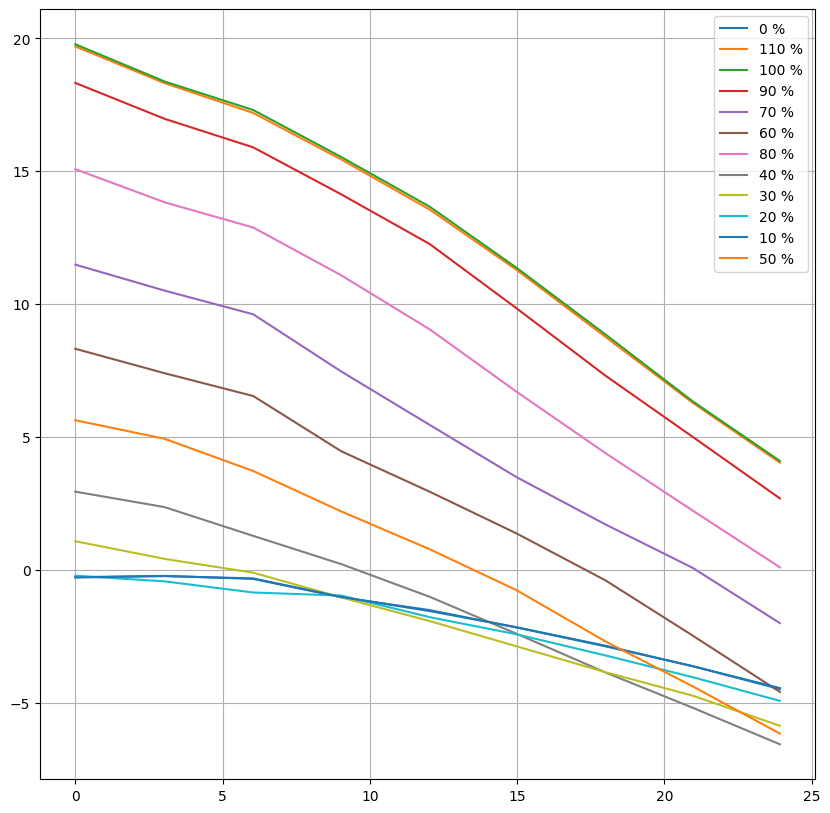

In [3]:
engine_dir = "../Data/Engine/Motor_1/"

engine = Engine()
engine.load_data_from_df(engine_dir)
engine.plot_thrust_curve()

In [13]:
from ICARUS.vehicle.plane import Airplane
from ICARUS.mission.mission_vehicle import Mission_Vehicle

for p in DB.vehicles_db.planes.items():
    print(p)

plane: Airplane = DB.get_vehicle('bmark')
mission_plane = Mission_Vehicle(
    plane,
    engine,
)

('bmark', <ICARUS.vehicle.plane.Airplane object at 0x000001568C2E9610>)


# Compute Trajectory

In [14]:
from ICARUS.Geometry.cubic_splines import CubicSpline_factory
from ICARUS.Geometry.polynomial import h_polynomial_factory
from ICARUS.mission.trajectory.trajectory import Trajectory
from ICARUS.mission.trajectory.integrators import RK4systems, RK45_scipy_integrator

In [15]:
t0 = 0
tend = 90
x0 =  [0, 20]
operating_floor = 12.5
elevator_max_deflection = 15
v_mag_0 = 17.38

# Polynomial Trajectory

In [20]:
traj_fun_1 = h_polynomial_factory(
    [
        x0[1],
        0.2,
        -1/300
    ]
)
trajectory_1 = Trajectory("SomeTrajectory", traj_fun_1)


# velocity is in the same direction as the derivative of the polynomial
g1 = np.arctan(
    trajectory_1.first_derivative_x_fd(x0[0])
)
v0_1 = np.array([np.cos(g1), np.sin(g1)]) * v_mag_0

dt = 1
t, xs, vs = RK45_scipy_integrator(t0, tend, dt, x0, v0_1, trajectory_1 , mission_plane, verbosity=0)

# Plot Trajectory


Simulation Completed Successfully at time 90       Max Distance: 247.07774139857437


In [25]:
import matplotlib.pyplot as plt

plt.plot(xs[:, 0], xs[:, 1])
# Plot the trajectory
x = np.linspace(0, 200, 100)
y = traj_fun_1(x)
plt.plot(x, y)

# Optimization

In [ ]:
from scipy.optimize import minimize

def objective_goal_poly(a,fig,axs, dt=0.1, plotting = True):
    x0 =  [0, 20]
    polynomial_i = h_polynomial_factory([
        x0[1],
        *[x for x in a]
    ])

    # Make trajectory name be the latex representation of the polynomial
    title = "$h(x) = "
    for i, c in enumerate(a):
        if i == 0:
            title += f"{c}"
        else:
            title += f" + {c}x^{i}"

    trajectory = Trajectory(title, polynomial_i)
    gamma = np.arctan(trajectory.first_derivative_x_fd(x0[0]))
    v0 = np.array([np.cos(gamma), np.sin(gamma)]) * v_mag_0
 
    t, xs, vs = RK45_scipy_integrator(t0, tend, dt, x0, v0, trajectory, mission_plane, verbosity=0)
    if plotting:
        update_plot([trajectory], [t], [xs], [vs], fig, axs)
    x = [x[0] for x in xs]
    return - max(x)

def objective_goal_splines(y, fig, axs, dt = 0.01, plotting = True):
    x =  np.linspace(0, 2000, len(y)+2)
    y = [x0[1], *y, operating_floor]

    spline_i, title = CubicSpline_factory(x,y)


    trajectory = Trajectory(title, spline_i)
    gamma = np.arctan(trajectory.first_derivative_x_fd(x0[0]))
    v0 = np.array([np.cos(gamma), np.sin(gamma)]) * v_mag_0

    t, xs, vs = RK45_scipy_integrator(t0, tend, dt, x0, v0, trajectory, mission_plane, verbosity=0)
    if plotting:
        update_plot([trajectory], [t], [xs], [vs], fig, axs)
    x = [x[0] for x in xs]
    return - max(x)

In [ ]:
fig, axs = setup_plot()

res_splines = minimize(
    objective_goal_splines,
    x0 = [20, 20 , 20, 20, 20, 20,],
    method='BFGS',
    options={'disp': True, 'maxiter' : 3000},
    args=(
        fig,
        axs,
    )
)


y  = res_splines.x
x = np.linspace(0, 2000, len(y)+2)

spline_best, title = CubicSpline_factory(x,y)
trajectory_best = Trajectory(title, spline_best)

gamma = np.arctan(trajectory_best.first_derivative_x_fd(x0[0]))
v0 = np.array([np.cos(gamma), np.sin(gamma)]) * v_mag_0

t, xs, vs = RK4systems(t0, tend, dt, x0, v0, trajectory_best, mission_plane, verbosity=0)
update_plot([trajectory_1], [t], [xs] ,[vs] , fig, axs)
